# Enrichment for genes DE between neighbouring stages
Genes whose expression changes strongly between two neighbouring stages were selected with two different methods (described below). These methods also ensure that genes do not change between many neighbouring stages.

In [1]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
    
import warnings

import pandas as pd
from IPython.display import display
pd.set_option('max_colwidth', 70)
pd.set_option('display.max_rows', 500)
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

from orangecontrib.bioinformatics.geneset.__init__ import list_all

import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from networks.functionsDENet import loadPickle, savePickle
import stages_DE.enrichment_library as enr
reload(enr)
import stages_DE.enrichment_library as enr

In [2]:
#Path for expression data (mergedGenes_RPKUM.tsv)
dataPath='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
#Path for results
pathImpulse='/home/karin/Documents/timeTrajectories/data/stages/DE_across_stages/'
pathDeseq='/home/karin/Documents/timeTrajectories/data/deTime/neighbouring/'

## Used gene sets
Use gene sets that do not have less than 5 or more than 500 genes. Use all ontologies.

In [3]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=True,set_sizes=(5,500))
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})

Min size 5 Max size 495
N sets {('Dictybase', 'Phenotypes'): 209, ('GO', 'biological_process'): 52, ('Custom', 'Baylor'): 15, ('GO', 'cellular_component'): 24, ('GO', 'molecular_function'): 35, ('KEGG', 'Pathways'): 96}


In [4]:
# For conversion of gene names to EID
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
all_gene_names= genes[(genes != 0).any(axis=1)].index
NAME_EID=enr.name_genes_entrez(gene_names=all_gene_names, key_entrez=False)
ALL_GENE_NAMES_EID=enr.convert_EID(genes=all_gene_names, name_EID=NAME_EID)

## Enrichment report

In [15]:
#Result filtering
MAX_FDR_DE=0.01
MIN_ABS_LFC_DE=2
MAX_N_SIGNIFICANT_DE=2
#Enrichment
PADJ=0.25
MIN_OVERLAP=2
MAX_FE_BAR=70
MIN_FDR_BAR=10**(-10)
LFDR_BASE_BAR=10
# Any colour map from https://matplotlib.org/tutorials/colors/colormaps.html
#CMAP_FDR_BAR='gnuplot'
CMAP_FDR_BAR=['#bede57','#5fb526','#36801d','#015713','#000803']

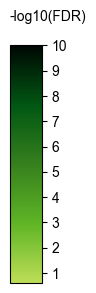

In [6]:
#Colour fold change legend
%matplotlib agg
fig,ax=enr.plot_legend_enrichment_bar(cmap=CMAP_FDR_BAR, min_FDR=MIN_FDR_BAR,used_padj=PADJ,base=LFDR_BASE_BAR)
display(fig)

In [7]:
# Load data
data_deseq=pd.read_table(pathDeseq+'combined.tsv',index_col=0)
data_impulse=pd.read_table(pathImpulse+'DEacrossStages_summary_mainstage_WT_0.001.tsv',index_col=0)
data=pd.concat([data_deseq,data_impulse],sort=True,axis=1)

In [8]:
#Extracts comparisons form DESeq2 results. Assumes that the same are present in Impulse
COMPARISONS=[comparison.replace('_FDR_overall','') for comparison in data.columns[data.columns.str.contains('_FDR_overall')]]

In [9]:
#Count N significant comparisons
for gene in data.index:
    data_gene = data.loc[gene, :]
    significant = 0
    for comparison in COMPARISONS:
        # Stages were compared
        if data_gene.index.str.contains(comparison).any():
            if abs(data_gene[comparison + '_log2FoldChange']) >= MIN_ABS_LFC_DE and data_gene[
                comparison + '_FDR_overall'] <= MAX_FDR_DE:
                significant += 1
    data.loc[gene, 'Significant_N'] = significant


### Filtering by restricting N of DE neighbouring stages
The genes for each pair of neighbouring stages are obtained with the following two filters:
1.) Gene is DE between two neighbouring stages, based on abs lFC (e.g. >=2) and FDR (e.g. <=0.01).
2.) Gene is not DE according to the above criteria in more than 2 neighbouring stages.

***  no_agg_stream selected: 952 with EID: 946
Genes annotated with a gene set in reference 37.8% and group 39.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 219 out of 373 group genes used for enrichment calculation.


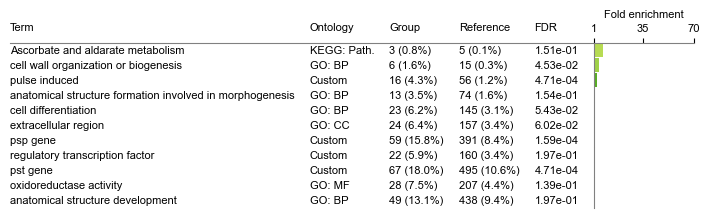

***  stream_lag selected: 68 with EID: 68
Genes annotated with a gene set in reference 37.8% and group 46.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 23 out of 31 group genes used for enrichment calculation.


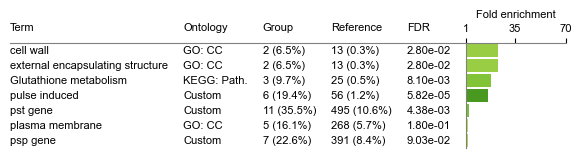

***  lag_tag selected: 609 with EID: 609
Genes annotated with a gene set in reference 37.8% and group 53.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 255 out of 320 group genes used for enrichment calculation.


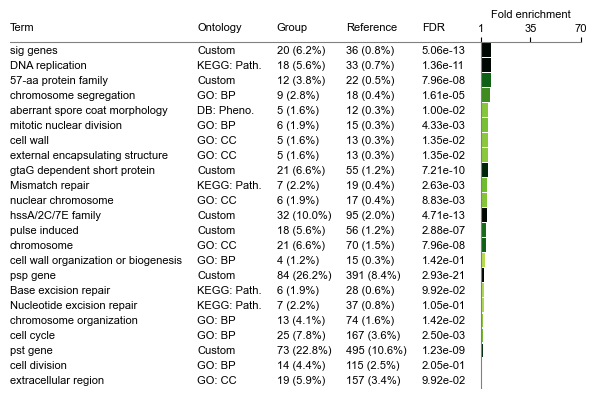

***  tag_tip selected: 148 with EID: 147
Genes annotated with a gene set in reference 37.8% and group 54.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 63 out of 80 group genes used for enrichment calculation.


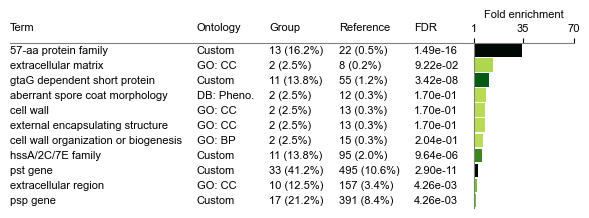

***  tip_slug selected: 59 with EID: 59
Genes annotated with a gene set in reference 37.8% and group 64.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 35 out of 38 group genes used for enrichment calculation.


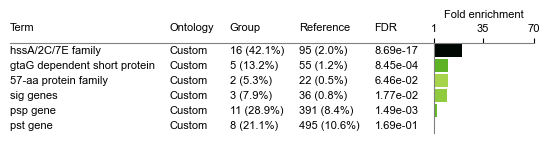

***  slug_mhat selected: 405 with EID: 400
Genes annotated with a gene set in reference 37.8% and group 40.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 90 out of 158 group genes used for enrichment calculation.


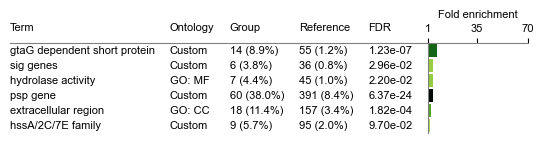

***  mhat_cul selected: 166 with EID: 164
Genes annotated with a gene set in reference 37.8% and group 31.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 31 out of 51 group genes used for enrichment calculation.


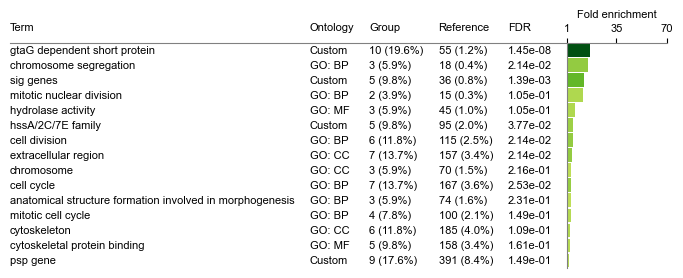

***  cul_FB selected: 132 with EID: 132
Genes annotated with a gene set in reference 37.8% and group 33.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 20 out of 44 group genes used for enrichment calculation.


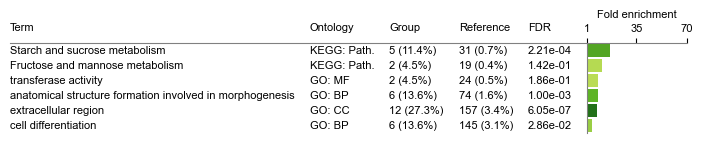

In [16]:
%matplotlib agg
figs=[]
for comparison in COMPARISONS:
    query_names=list(data.query('abs(' + comparison + '_log2FoldChange) >= ' + str(MIN_ABS_LFC_DE) +
                      ' & ' + comparison + '_FDR_overall <=' + str(MAX_FDR_DE) +
                      '& Significant_N <=' + str(MAX_N_SIGNIFICANT_DE)).index)

    enriched=enr.group_diff_enrichment(query_names=query_names,
                                       group=comparison,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all')    

### Filtering by using stages identified as transitions by ImpulseDE2
The genes for each pair of neighbouring stages are obtained with the following two filters:
1.) Gene is DE between two neighbouring stages, based on abs lFC (e.g. >=2) and FDR (e.g. <=0.01).
2.) ImpulseDE2 identified gene as DE expressed through stages and the transition occured between the two neighbouring stages.

***  no_agg_stream selected: 581 with EID: 576
Genes annotated with a gene set in reference 37.8% and group 39.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 73 out of 225 group genes used for enrichment calculation.


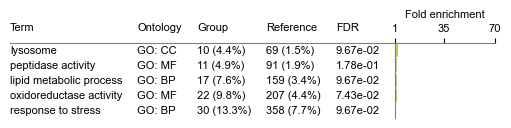

***  stream_lag selected: 27 with EID: 27
Genes annotated with a gene set in reference 37.8% and group 37.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 4 out of 10 group genes used for enrichment calculation.


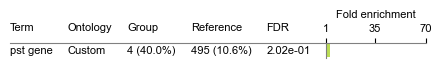

***  lag_tag selected: 303 with EID: 303
Genes annotated with a gene set in reference 37.8% and group 46.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 110 out of 140 group genes used for enrichment calculation.


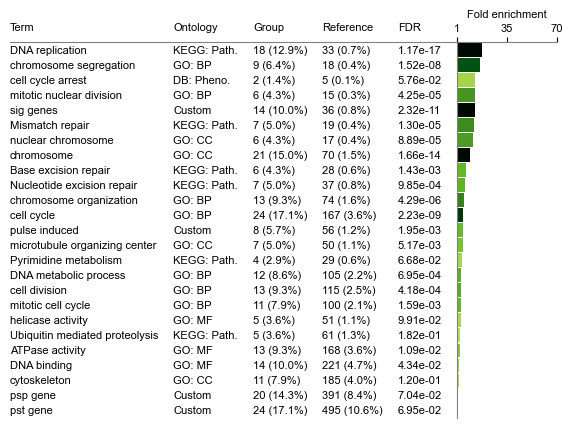

***  tag_tip selected: 61 with EID: 61
Genes annotated with a gene set in reference 37.8% and group 51.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 22 out of 31 group genes used for enrichment calculation.


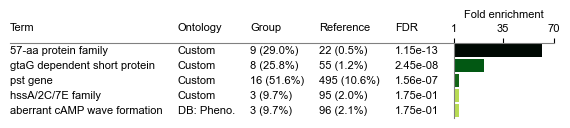

***  tip_slug selected: 12 with EID: 12
Genes annotated with a gene set in reference 37.8% and group 100.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 12 out of 12 group genes used for enrichment calculation.


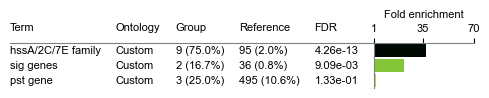

***  slug_mhat selected: 168 with EID: 167
Genes annotated with a gene set in reference 37.8% and group 44.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 42 out of 73 group genes used for enrichment calculation.


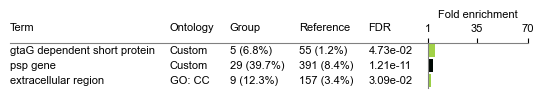

***  mhat_cul selected: 114 with EID: 112
Genes annotated with a gene set in reference 37.8% and group 33.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 16 out of 37 group genes used for enrichment calculation.


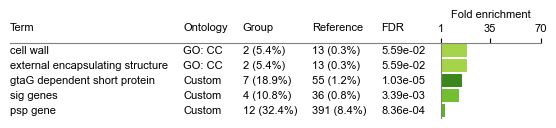

***  cul_FB selected: 133 with EID: 133
Genes annotated with a gene set in reference 37.8% and group 29.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 16 out of 39 group genes used for enrichment calculation.


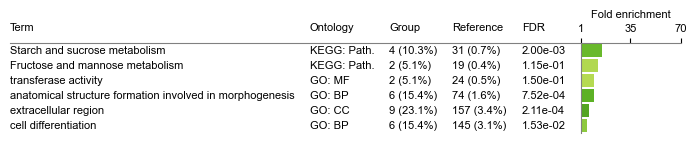

In [17]:
%matplotlib agg
figs=[]
for comparison in COMPARISONS:
    query_names=list(data.query('abs(' + comparison + '_log2FoldChange) >= ' + str(MIN_ABS_LFC_DE) +
                      ' & ' + comparison + '_FDR_overall <=' + str(MAX_FDR_DE) +
                      '& ' + comparison + ' == 1').index)

    enriched=enr.group_diff_enrichment(query_names=query_names,
                                       group=comparison,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all')    

***  no_agg_stream selected: 2241 with EID: 2229
Genes annotated with a gene set in reference 37.8% and group 44.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 502 out of 976 group genes used for enrichment calculation.


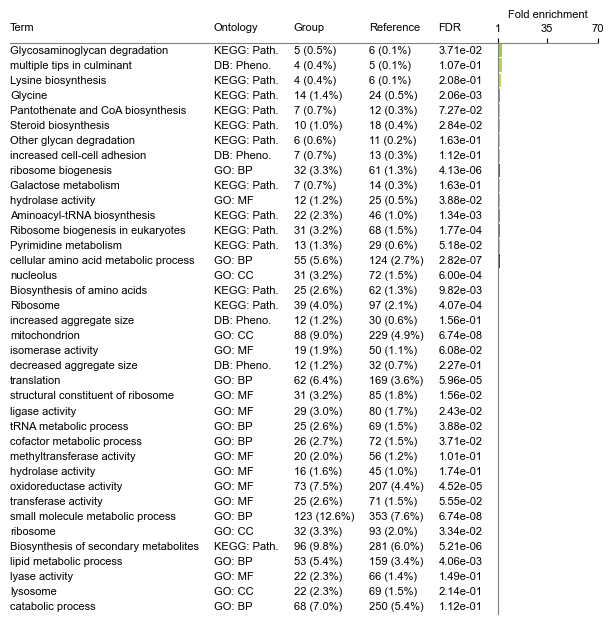

***  stream_lag selected: 138 with EID: 138
Genes annotated with a gene set in reference 37.8% and group 41.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 32 out of 56 group genes used for enrichment calculation.


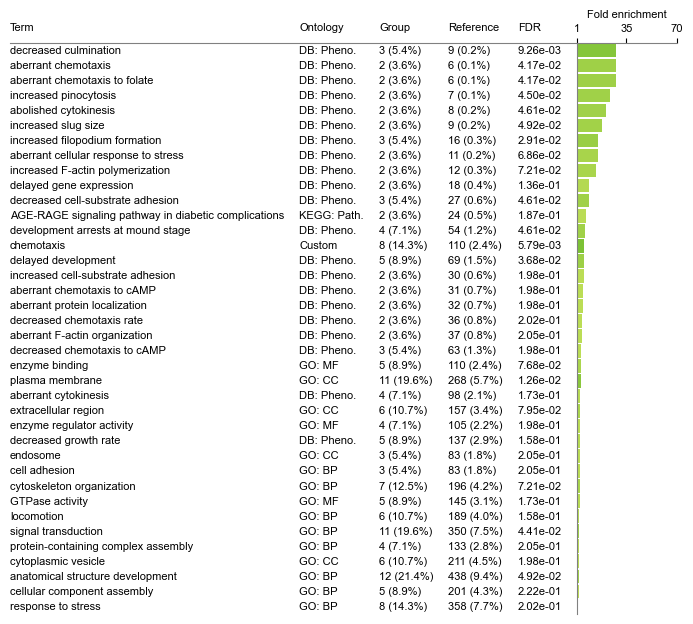

***  lag_tag selected: 673 with EID: 671
Genes annotated with a gene set in reference 37.8% and group 45.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 183 out of 299 group genes used for enrichment calculation.


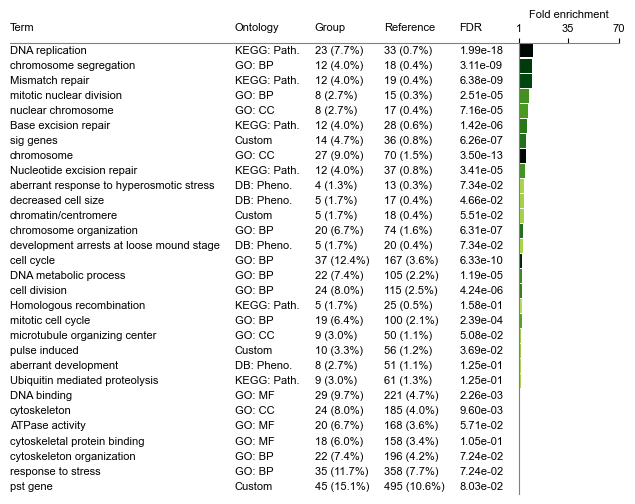

***  tag_tip selected: 306 with EID: 304
Genes annotated with a gene set in reference 37.8% and group 49.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 79 out of 150 group genes used for enrichment calculation.


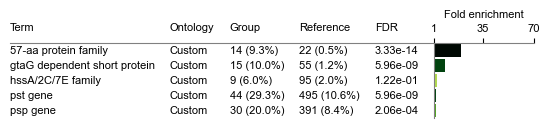

***  tip_slug selected: 64 with EID: 64
Genes annotated with a gene set in reference 37.8% and group 56.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 25 out of 36 group genes used for enrichment calculation.


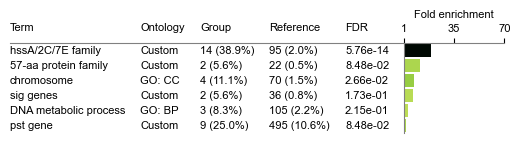

***  slug_mhat selected: 576 with EID: 574
Genes annotated with a gene set in reference 37.8% and group 46.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 83 out of 265 group genes used for enrichment calculation.


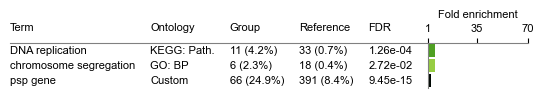

***  mhat_cul selected: 355 with EID: 350
Genes annotated with a gene set in reference 37.8% and group 41.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 50 out of 142 group genes used for enrichment calculation.


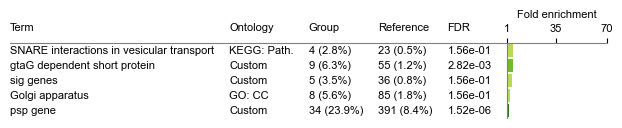

***  cul_FB selected: 243 with EID: 242
Genes annotated with a gene set in reference 37.8% and group 36.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 42 out of 87 group genes used for enrichment calculation.


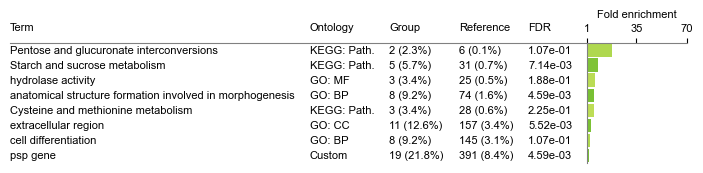

In [18]:
%matplotlib agg
figs=[]
for comparison in COMPARISONS:
    query_names=list(data.query('abs(' + comparison + '_log2FoldChange) >= ' + str(1) +
                      ' & ' + comparison + '_FDR_overall <=' + str(0.05) +
                      '& ' + comparison + ' == 1').index)

    enriched=enr.group_diff_enrichment(query_names=query_names,
                                       group=comparison,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all') 